In [1]:
import csv
import subprocess
import shlex
import json

import numpy as np

from io import StringIO
from matplotlib import pyplot as plt
from scipy.stats import kstest, expon, combine_pvalues
from IPython.display import display, Markdown
from tqdm import tqdm

In [2]:
target_directory = json.loads(subprocess.run("cargo metadata --format-version 1".split(), capture_output=True).stdout)["target_directory"]

# Turnover Rate Test

In [3]:
def test_turnover_time(
    algorithm, speciation=0.001, seeds=[42], sample=1.0, size=100,
):
    total_pvalues = []
    total_turnovers = []
    
    for seed in seeds:
        # Configure the simulation
        config = "".join("""
        (
            speciation: {speciation},
            seed: {seed},
            sample: {sample},

            algorithm: {algorithm}(),

            scenario: NonSpatial(
                area: ({size}, {size}),
                deme: {size},
            ),

            reporters: [
                Plugin(
                    library: "{target_directory}/release/deps/libnecsim_plugins_statistics.so",
                    reporters: [
                        GlobalTurnover(output: "{output_file}"),
                    ],
                ),
            ],
        )
        """.format(
            target_directory=target_directory, output_file="/dev/fd/2",
            algorithm=algorithm, speciation=speciation, seed=seed, sample=sample, size=size,
        ).split()).replace(",)", ")").replace(",]", "]")
        
        # Run the simulation
        turnovers_io = StringIO(subprocess.run(shlex.split(
            "cargo run --release --features rustcoalescence-algorithms-monolithic,"
            + f"rustcoalescence-algorithms-independent --quiet -- simulate '{config}'"
        ), check=True, capture_output=True, text=True).stderr)

        # Read in the speciation times
        turnovers = []
        with turnovers_io:
            reader = csv.reader(turnovers_io)
            next(reader)

            for row in reader:
                turnovers.append(float(row[0]))
        turnovers = np.array(turnovers)
    
        # Calculate in the dispersal locations
        gof = kstest(turnovers, expon(loc=0.0, scale=2.0).cdf)
        
        total_pvalues.append(gof.pvalue)
        total_turnovers.append(turnovers)
    
    gof_statistic, gof_pvalue = combine_pvalues(total_pvalues)
    
    if gof_pvalue <= 0.01 or gof_pvalue >= 0.99:
        display(Markdown(f"## <span style='color:purple'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.05 or gof_pvalue >= 0.95:
        display(Markdown(f"## <span style='color:red'><u>{algorithm}</u></span>"))
    elif gof_pvalue <= 0.1 or gof_pvalue >= 0.9:
        display(Markdown(f"## <span style='color:orange'>*{algorithm}*</span>"))
    else:
        display(Markdown(f"## <span style='color:green'>{algorithm}</span>"))
    
    display(Markdown("#### Fisher’s combined KS test:"))
    display(Markdown(f"\n* p-value: {gof_pvalue}\n* statistic: {gof_statistic}"))
    
    plt.title("Distribution of p-values")
    plt.xlabel("p")
    plt.ylabel("pdf")
    plt.hist(total_pvalues, density=True)
    plt.show()
    
    display(Markdown("#### Turnover histograms:"))
    
    turnovers = np.concatenate(total_turnovers)
    
    # Draw the turnover time histograms
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    x = np.linspace(np.min(turnovers), np.max(turnovers), 1000)
    loc, scale = expon.fit(turnovers)
    
    ax1.set_title(f"Individual turnover times PDF")
    ax1.set_xlabel("turnover time")
    ax1.set_ylabel("pdf")
    ax1.plot(x, expon.pdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax1.hist(turnovers, bins = 1000, density=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax1.legend()
    
    ax2.set_title(f"Individual turnover times CDF")
    ax2.set_xlabel("turnover time")
    ax2.set_ylabel("cdf")
    ax2.plot(x, expon.cdf(x, 0.0, 2.0), color='red', linewidth=2, alpha=0.5, label=f"expected: loc=0.0 lambda=0.5")
    ax2.hist(turnovers, bins = 1000, density=True, cumulative=True, label=f"observed: loc≈{round(loc, 3)} lambda≈{round(1.0/scale, 3)}")
    ax2.legend()

    plt.show()
    
    display(Markdown(f"#### Parameters:\n* seeds: {seeds}"))
    
    display(Markdown(f"#### Configuration:\n```rust\n{config}\n```"))

## <span style='color:green'>Classical</span>

#### Fisher’s combined KS test:


* p-value: 0.19077882919253103
* statistic: 2055.175970214682

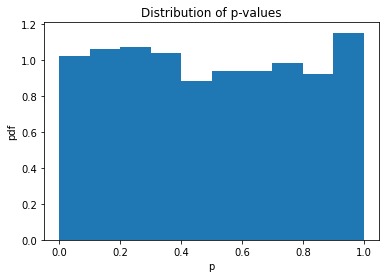

#### Turnover histograms:

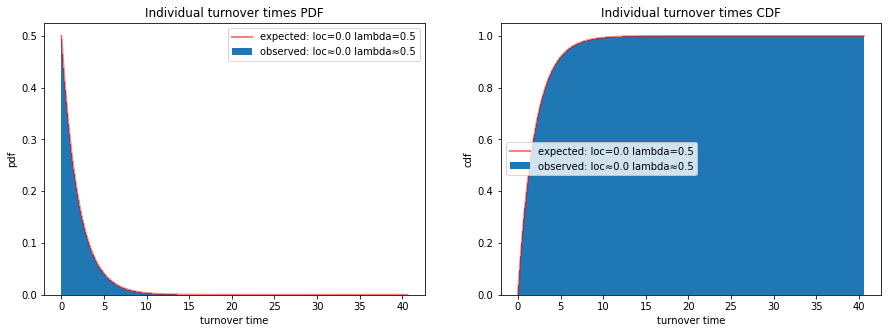

#### Parameters:
* seeds: [13132594850384837018  9280560822995218808  6418013966522514717
  7321529884289840085  6151371146090910178 12036953004897203446
 15000893213595391397 17928493312716759093  9329914432158601726
 17329723224840037361 10439396257070931835  8496963392550756608
   967425418942782813  3124667207308830375 16724723688714389027
   632138519051947154 13515131377489235434  8884078769945396871
  4096698796327516933  5746636325816815587 13753707676388647525
  6529969868638702607  9943444994936408450  9563044363976395298
 11272283028973213666 10835783634504410590  4235465282526116919
 13213246349989062420 17672240780212219796 18351763023784187265
  8120617840648205987 14410839078771674147 15971338111969302316
  5190852733951497705  5042733487676035321  7115158568568603853
 11367775581106681202  9207869217476376355  6232005391118149364
   879247243819305331 17880970538488128689 13603703255345459573
 11321536323749921178 10522328314455240488 12371734306848581696
  5561925891417136648  6859138532769050147  2310080376482182939
  6757794624915005298 13273087419989947791 13258235302534324239
  2888069246218993320  5739381235739592998 12122879752955255676
  2758753142682162119 11867143019625597156  9841593401136792022
 14648430612761239729  6793686027404227043  3447812355619400030
   259523236154008881  7864121390907104543 17689976673217415133
 17414011673724294517 15985218202285681680  4931648845528278922
 17407834147195312721 17670194591888843562  7033675917692059209
 12991638664565940709  6627250204681858700 15204413286588771088
 12471246656434948728 12670510743675984901  4848312605258126138
  9784265202671380828 13672386876964959775  9240444379578968680
  3279774979241758600  5387277226328792080  8263665070806130874
 10141628474908414427  9069421426933383400  4427633800211640800
  7813061940693032342   138447382311549124  6845531642210838231
   322414491929655002 11786635580687573845 12689269066090589783
  4627727034275237706  4109108525585306553  2861991417558783021
  8954457799008826000   376715859114105346  1863474163293630496
  2518640167150112692 10502332473605290874  3779846384377193066
 10015737397824756926 11329186951598250487  2751953701990903393
 12219428852711836700 11327075570663038900 16119265157510754012
  2060903283731222741  7710755402621299115 10979463721517538655
  6386999083812653758  1218444204611766128 14985364011182054517
  6163692394065886175  4030698972267007364  5156715847722239169
 15144855960739409728 17805598036721671577  5698915222275556439
  2905454495942563639  2128269745706226081 16951047629715531712
 13642653637103305553   624232518746030080 16920923811633041445
  8748518145378723146  6673988680602039251 17999526499660840036
 17282453396960215384  5456622575799132834  2266706300345229533
  4492867697412769366 17539578103314479821  2663239772299726603
  4565663789583762317  5915344925330861353  2743625945176329191
  8920412477826226989 12256958284635363689 17675283687880517543
 11714909388990937434  7842125729985951378  7759602916982388089
  4459041250593892829  1978540023411737762 14805834139226603905
  5020706962406347900 10466183482364929271 16727007419421991283
 14635693891682945214 15540287067112324748  7268678510686728616
 16351404564230521600   307396540277275911 14650103981301879252
 13747913956624880107  7356692077838634155 17294844399608429073
    86687394045953115 16591384534280374901 10909304252223508593
 14426457987454513838  1394943210803228560  1546028549454556255
  2259542760777859203 15247824611977159949  3448202129157337961
  7255891113210740612   128807992187352801 15867350822998201764
  4871831758451625303 14615035470999128756  6264331402464417074
 14218883066366269499  3215051842546425890 11550371519888007062
  4736613490700667565 16429450203325216413 12537191653447550108
  2264558345934538774  7073364993784107430  5081322460104287778
   678028011585597852  5349786984822211773  2095881102233619579
 15046110538724485210  5061318248712172179  8136784278951104476
 13953157900131047594  6654323992145475561 15431186078625860347
  8461727736378080690  8576723002958758183  7208988968311445183
  5618435095747368456  9624596751999509002 10294257633167947444
 12726455973988302442 13755418730225796621 11958463755380735088
  6450914944012729890  9238811286647536982  1747335407531567528
 13410811496151801739  3293555893414189909 13044127298757021940
  9393728466288814731 14514825813787866698  4573299282371316016
  9802730948372859346 14150939689386283484  3010788410485792900
 13059412431050199498 17613263883336711339 13781760716658999322
  5708679139292696922  2562005565161593929 12590652613249357949
 11612309518098619824  4006243789290880456  3623526402022775164
  2515349084385217882 10360966705686927612 16359507328738946611
 14727390603608523496  3721187556668439352 14696293459225645382
 15663579481383770565  8375045164288456197 12325904685782500563
 11514680316965089099  8441804602178358631  2062071514592291836
 11766699930865630265  7992021937419921897 10492618918620691853
 16855022949472700326 14935486804157443627 10175779574846461649
  3710189023338876922 12238153362481295679  6852543042513982506
  4475139763228149050 15064671316457917970  9071226139640337796
  4028786828513876910  3406600534352138042  9429228869718158057
 10408717336988844023   358239826642742790  9651129770182726660
 12619448745560361322   965886413943985136  6642591993482029721
 17720343013757521601 11246442198726470248 15154252300012307101
 10364572602356463564  8833183207086662252  9311322004698594310
  9907678071961248418  6414393143955865358   277689890015489335
 14025164605354554394  4409074320711194422  3600483872237036064
 12936979495458595502  2035629617958215498  1173243802597449247
   565907526740354203   106205268235003351 18299670052814825988
 14498538634183775360  7859381390146229160  1195983507922076488
 14910442721366326035  6168337269987551886  5509728657958569428
  1609796246133375034 13931238259872043690   303074157559507540
 14114506859543604703 12737502702417751511 17209997354484933822
 15743507844801706184 10437712047865226821 10495852677636036367
  6720349005423494287 16286545954038176979 13608236096286621672
 15075446801944727585  9793351128146493609 14547230365253697890
 16318151396855974836   825527265423490756  9761086360502806212
  9093556152284211560   738858404386691408  9236302069881269878
 14705685472026866255 17457541602008954557 11765866338685255012
 11153923722320290819  2871286474741500007  5039696734768281282
 11409105824294166220  4577556606678519094  9788396066942057582
 16772385247250789234  6623042118174448438  5982818240670663325
  5242087323211510088 17866255162531191665 17691980723801866160
 17264204248232785953 11859105856020296009   207367949443930687
  5513222393923904699   540774940126771218  3670637611226677490
  6641007353159027147  1359509529780981388  9302652221890357786
  2029099447634975404 11146470048664454849  3243422643113398634
  1108587962594246865 13661165768785925703  6856049554140535656
  4601661458402218100  3312545365294425718 12113756215787471849
  4551449700695614842  2494030134166990072  9809307851963114072
 13489303359928943312  4807721583947571324 16159042459830948703
  1969279336502751471 14265641789865955202 17976444947325692701
 13623815688624408457  7952169980296680966 10472862608564326110
  4259230955348984295 13671650209202032910  1869809178956796021
  6339914738517527433  9760516451007853696  4876789753408377607
   669669182448900014 16107696885908428832 10698347168578188731
 11868191415253277326  8496408696396287882 16786436939606667229
 13477263476051193159 17673312600793024464 14224616376241977798
  3689806151765161486 14308226005606708647  4533664806320534470
  2962506028070538384  8517924274474289260  1181982581241736439
  7274071674954249935  8340695827950752554  5746871253037285709
  3939085990459487839  8686434889669460280  3705355865385816353
   352701836488199270 11049980578119014037 13282670240583158005
  5841397450736707757 11510174322918862709 14821976883612777444
  2770223138120037158  8546520688384362342 12345123219452471640
 18309337387236669387  8874492109614838207  6822017607352634490
 13954351192679004883 15181791684888136999 14700443895611195777
  1113222474972126929  8878573861392253216  3289884251424680287
  8175149847731469648 17268933836268601388  7123425999223505888
 10166927043340273284 11848407721210529900  6210927297780127809
  4378917398340011344 12730957416560460322  1183113984042559922
 13151387704889330063  1849053550603182997 15000654933814656483
 17355569024538257252 17447922609650445380 15932101101437479379
 15910936134104716253 13920951510452378880 16402477679633048165
  5371043329891295430 17459064125924235733  9246268319873865606
  9969011727474140942  4207192241526478491  6438841798072090971
 16968727400897722716 17053085268268370375 11127112284738755591
  6772649811040419606  1246710796105305456  1248278209433164418
  2318965352763934166  4459183635170850756 11209629027313350394
 17584456597836231500 16566202199490669478  3722946343336367787
  3514192621810000285 14683171371120687370 13994474763263641501
  8303737627180921021  6516866305393745187  1123670338110318524
   155980780009744310  8323729832924316574 10903623909645007375
  5023678636187917485  3367305069144188958 14885115742756378754
   471117565826799050 10396947802697903799  6580740311267776617
  3913855589223514983 11320179886314758891  2172906286469304673
 12115009408782281724  5304305612012520573  4060232748791765889
   397263260861898061 13596361842179641949  8730977833757570137
 10348987977559254120  2295409690824895800  6417120323624606079
 11270631038428251627  9242467329732664676  8458553431660300052
 11838018991348911920  3906741280484579974 12110096794865441116
  1978199567907088170  5541312075042851732 11146820022278025987
  3691066432665233519 16068740398382889121  3135795404371048640
  4136583163131657549 13150720954302038722 11400399214011342474
 10904320182528848451  2645202109440116918  2011253698337540398
 12838410599064442016  8642263113456321394 10449037738683723603
   395851313138320028  9175062828104999148 16292422768847983571
 17320880247637103239   462870306990791263 10661307387074057077
 11684550367374482588 16119724513720799316 15908410990246623924
   786155979565080467  3764433570118251977  1317372072011789203
  2382113291045295959 11776940074041579626 11647566681548076930
  6379173127661891266 11314132904450824582 15475598638042353110
   326940129748789635 14595029331347407959 17920386328628803178
  9298770521697458204  4372394559750985861 12065950117011702501
 18045420383393634387 12554245177817980890 15485114778980087006
  3388699984074647512  1861725215703126607  9551012149802861905
 17411940714748490978 12139263726696533002  3388306802591065936
  5165307125203046180  6129953945079408696 11158168026104087911
  8098179318003045091  3078526546121782001 15109283292357400758
  1782857154310893445 14832640793207251274  4974960941224019112
 14860271065222408482 15746438050092766119 14879181380763803852
 14296961783424083079 16058604546469050758  6884334794858794532
 10904631854792617863 14842928831630499203  1948717326024686082
  9525832702031641759 16562737483041705461  9449581344914114773
 11586053993987008858 13887792150919630213 15096143004799378396
 16978999033320213133  8415010603254304504 11693381412216148515
   177256126084246882  9350440559540191636  8633973683113054657
  9161276819076537734  3317049219249615966   384652102343456347
   609137576514809428 15339187672908753074 16879036515236821994
  3394322143893286047  7721376749106039824  2792174145600447590
 17353928180846514849 12771814904542621560   343542932642538515
 15081358906682813078 15449588472872796040 13273556875054253416
 13423933593452047811  7671803757055309244  2487121668782666293
 16589380780625854307 13541715372995547269   321470964815955356
 13836099527337309887 14416783911703416465 11910878390760943187
  4878517671785618145  7210018368208782297  8539936904476923317
  4735478616160294668  3665228616435765292  9213777713513207053
  2850547681929884327  7172161648005040904  5818562312381393470
 14861285258006502598 10149843510598333232   493281188684994779
   414373176897299376 13997496355424004765  2976230938414020952
 16328426952334272380  5379869424737948807 17032230012378394967
  3972103831432411931  3103308809931532411  3252192567386872931
  6670900535656944100 15742275457442364135 15620223104162115829
  8921730074107879113   368822515533010712  3801219410919638582
  6962923126196025144  4650735760347461960 15654941147786733505
  4082374102163909177  3148472534804421257  7346167785099304016
 17501450736288611060  7723665960082989877 16438055521666350710
 11543942472114408427 10523998248482719766 15034160997845337606
 14172136405660413725 17725819822785948266   670894658243390539
  6893606397943806875 17485949982363789257 18298873808815429922
 10955259052045131688  4878687542766695405  6070381776596204443
  6155849689085299010  8473793356083655123  9775651050905439992
  9384309871575837866  1856703635575008171 15532525468771640704
  3692738153880588977 12962986975640906647 15472358940363655162
  1178738318175618028 15553791334062257941  5960110861059753629
 17217683334797488497  4132438338909309538  2912537742329691941
 14796967029966289698 10404907438844555804  4550742160260332535
  9847135141051576387 16406333596660256537 17957149626518049429
  5277534197832860329 10733281306203559541  3472714265079580040
 12590661175930082449 11928267371621243879 13282055655044717855
  5194469270717328387  4286984702876885892 18401466534533121930
 17082171240491943731 17999598001702825476   897148084058691429
 11113254093247397353  1797203561007898759 17688301933115031966
  8297357198176628224 17775574572667286708   326665904133651530
 17108289023864520806   953317931251638964  2989805924102493185
 17846279259118929177 15863002921684061180 12049069351069197359
  6779654425326272370  8459595955354837306 14608942852596001966
  6981471029163434499  2159233459263621601 12573833619006556584
  4129969348813742137 13723014671592695615 14441438540151026402
 11144250454349491415 14177939434607851286 10719026137986140254
 11025663547997989878  4353911803951243142 15437406660834277191
 17983548488353491251 16647650883750868778 16202415544423131620
  3430859658818891931 12235433694459992011  3756065137398848963
  7083261675149822503   827416927412988463  8848807324850026940
  1676436730182268905 16339091933907840823 13037080213917988129
  9418290346875333833 16967449733910416792  4060869253950410207
  2427942845262271335 13078511201171841330 17313062743568898429
  6529813440202040606 14112867687437464099  9269611172295277742
 14017686325646820256 12547110159580189955 11874371121448258438
 15647891331265463219 16827113852650600904  6520904568504850272
 16578007713564795900  2591760231049848857  6003916040743427051
 15013733036772462680 11982042801502090953 16455455739887236683
 17936470080605814095  2330499241564454695 12087143970610204218
  6931025729363516939  5810393136700114042  4011223741699086436
  4118813791070224725  9731646094853494653  4366812340987234301
  1619684169427553582 17700289273022280894 16214662726717719608
 14723930529999032031  8973289835152579302 12251830718787886766
  3615391503491644591 11485919767408007356 12369932850732489580
  1645577138019574655  8670662879370346001  2073887735023805785
 11994171061386527880   318843391351681153 12610626706584497255
  6710034460463874886 16469875151735320872   737399358036408680
 17847694754661420811 15994834123649931614  6309102172412257747
  8400329454333015493 15473800008245393077  9058923351629012905
 15104424748643909143  8042728076080953416 17019338457257646636
 16326620613522032890  6207750475156970369  2695535226707196635
  9255246760263535266 12238116462096168924 18402995761738104421
  2575204280344428254  6784493773900655948  6767334425950297471
 15624870449557688219 11836929528891445488  9388073124813482964
 14278899866853888829 16276649298514050814 17304651060540074985
  9874946764848182310   980861851187334565 14308162041675274281
 12218987682955118116  9381700658227758019  7389600027817593320
 14471429630587913868 14265208645334134171  9232635096094952679
 16791289637567667108  9325119816993603858 16384221801013525109
  5608636116168418684 15114247824311627530  6941019410775517018
  6040665471566558015 17396988572630101143 13471153486456630709
 12940719643723856636 12597337423345534632 16753559508050527054
 14137649109818627767 12289503454819552783  5853089501220151166
   672735334488707554   193056960551635676 16691022844913202046
  9857687082419040887  6863763999445809637  2919956513684077410
 12964628533782267470   382983274148305435  1890456801252315655
  3595052334604534470  4123369650287866304  6377258457612494078
 12501570633100215630  7166892331818346703 14488186484834618391
 16445769949274385946  9793231089080587639  4338014665775387004
 12231224744649296305  6498201479692085196 15894066863220773946
  6303295992013851951  4750420781715378581  1932839174840068362
 17043058891427429924 16667433181881643218  1628648722804008514
  9804531426708559885  1650587604539682206  2654464884592959320
  6886676537224855196  3084625562784777341 13998192822583683163
 15069063190190750067 14554538948193101848 14206543583657563975
  2557255213718127911 10377744655607909565  1591756528336719605
 12368567320286908332   396373815543600325 11984149314213527645
  3794928620642837958 15892932511461763630  5262533890747730964
 16056405388136988707  2098310249961147256  1574779047115216306
   234421381194300069 11526468661428361663  3572717151599797040
   315954848764746750 11992532721905096231 12066681964665916539
 18300340765024639159 18323344005691509403 12085603711656826049
  1792868526479189304 11266580176272800055   840457967401496858
  7228098550755858026 10661989607488493901 18431206667031029444
 16812207170333839858 11100426560617766464 16295656105886684297
 12894531328596756548 18022494159668125697   135292893815788202
 11663344756747494508  6411498738135086310  6654149277021747852
  8536658215190953853  1376363077757983200 18329560225146046230
 17240590348414705494  3956666037131517749  7185959582766593436
 11745108957198143632  8960854705387826752 11572094978612110164
  8314891996673885035 12136775409130821677  5507744075645076632
 13152514537299089909  9540025503019569123  5215369237559291967
  9687493248773898143 14680161781543998876 12558972126462457101
 16580634723277893660 16062854390748582131  1438624445738917293
  9401613883824612769  2691894616616167736  7562637694248058820
 13564244512046163154  8268929512539303082 13632774443545964534
 17201012289567153384 10003787692460201897 15909592422782716245
 12307685684559723655 11332681340317604786 13570405405965575922
  5621524632712863904  9913472272663344828 16261390790765823149
 12426977114110225839 13562974952851862176 11799570400335728971
  6903482858965074184 15340417050507439081  5673606512818201473
 14124246122820777415  3684175597096175340 17560588400481065917
  4362276635486377516  5463034607910372186   593243478375623835
  3620318440457499626 16990370779874825725  6582214338522449014
  6594061850226077097 12463650278595182619 16539325523650285738
 10302412458784894120 13657095508781387819 12874291322452644169
 13237474379352644637 11035388368720087725  4579402399806511929
 10141440800636447588 14009370593500562968 17141876929855058471
 12278898364282456533  8767278174647298377  5690901221233265085
  4922990245737982584 13364365257555899612  7910575278775124727
   615402764977007121 13253431886482187434 14343340070419563899
 16354847670074473685 16789175588431322940 13203911329500427339
 17130154392311774418  6935624580318337916 11635278930971444741
  7231965817397952311  2260904874244050271  2071661454173461889
 11781572212076354828  4655471208379338508  4725468323420490650
   289528172831016706 18082938235803098034 16149827834938346941
  7612871723645505652  2842526803113735390  7907463292942265610
  1823158601046803773  8826512444922508899  2460994947874237890
  8590551924692134397  8209991120152632941  1182691457924418899
  1582786745628133643  5845190618192323082 16266955125509759674
  3822911711051151645 17431434228215765353  2799745993709382308
  8036967594228565717 15881828551551926198 18216189604330889290
 17339278280289978594 17962477088664793290  4959850795216637172
  3326903339253207957  2868023605109629257  7390271779933339756
  7912356562086628261 15095824026622408640 15748153122073319191
 14298162955524073218 13257210200632495326 10791237778195361708
 13078177673310524685  4927911595886300544 13118294778522716589
  5452565738273172149  3035598258028426448 10850774924541064613
 10383585810196096642 15836409249101959969  6555017676929775505
 10541794042627584641  4810934742217158801  5185511492192807873
 12067128664998326695 11388161878567212774 13627794708252866501
  7578542202684299549  6112041742148699946  8177416551407343090
 13738419656880603683  5076210344367042874  6276409012686326903
  9360412129320459580 11457136637623290725 14741490053685430289
  6874254077528697783   933919470096915303  1448523403156576356
   963883813651572312  3849633723463030934   359799703763999547
 12374288484434130356  1179577323467358941  1232705655799098922
  1173360550873334216 10598879039333027721 11102536136580799610
  3963932752059737387]

#### Configuration:
```rust
(speciation:0.001,seed:3963932752059737387,sample:0.1,algorithm:Classical(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Gillespie</span>

#### Fisher’s combined KS test:


* p-value: 0.1599751037627954
* statistic: 2062.8837897475405

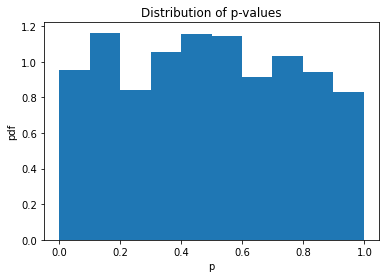

#### Turnover histograms:

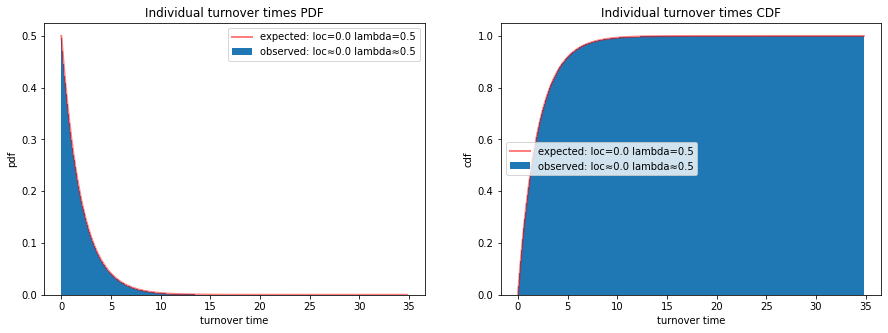

#### Parameters:
* seeds: [14446520854586556057 15140268313463129162 16618258970439376243
  2696231861446060928 11768380292771226967   858791935985688843
  8319305023629362152 10282473361877608486  2962714596876999578
  8062230202492618205 11299301682763100137  7168632639313402083
 13133113167115746742   470200195808936015 14428908136347868015
  4367009678087778416  7404408698661584666   365337222080151677
  9925026233322764593 11678547878789389241 12905418436883155671
 12937094574824065221  5340669047800579825  4588597483008537033
 10984769098811039544  8276748028227513116 12426578143189134233
  2676899150852301300  4124522327425698165 12725871598154483867
 17722000679837896861   852585026163632618  9323468506771825751
 13168882951498120307  8456405118108875306  3417395307583944820
  9250565066164199403  8052625672145655881 15034628320020963244
  3941346945616290411    72473040862200123  2430645976328527721
  1212892537241687576  1404388368752351042 17137934149299615616
  6152824923198691984 11360586358123572667  1426791858663336854
 12076696560014534597 15383757314303204231 14949511594147087941
  7419411902731272268  6117642467996305964  1313387384671359676
  1502396881848341459 12274978349545258542 11434714324401960177
  7548237123896323229 12421725444370922205 15884952109461203154
 16155194660843388562 18234590514341607256  1955363535588252868
 13583473642560002989  1135352054210228963 17078431822615793475
  3915622132682057387  1909997508006576194 17260089373266111391
 12262154783755398492  2219098952498529977  4203289217663901518
 12065113721704637145 13657134801935666166 18395889572408900152
  5191002352197525866 14387917996227365715  5380341169439695808
 16902356429518202382  9848170964419702308 15394797103770380957
  2377235196242148369 14175099089030757012  1646523563633781985
 11211000846836416171 15076601066145734912   341752259333654296
  9043268324707526129  5702805204960878833  4596047618997360574
 10786438018636745105  8763389947616391174 17237515734524419520
 12405913925048647880  3773321418420642790  9441630653680846962
  6863748513941102223  4707461215012440037 16403686742947014724
  1342782675365037264  3710355001422213752  2151273338950407896
 11663730264087906634  6987865766233271879  6008316012764732558
 14861840669899827760  6643801147744131544 12798858478666588270
   222973475605846165  7978076070276876135  2112926977901319140
  2630964797724305687 12386033411882716413  5547246528816136471
  6632796492193497019 11749415324637446562  7712835653237106202
 16129156846008761402  6402611417835678029 13859639121657736275
 18399721559914066941 14804613290735435520 10981100259190959476
 17820137621355494591  9214337822104408203 15182701407358022870
 10106220527667380036  3706182725333625635  8939537867858822681
 16206152977008403452 13690832925124262483  5904076142106381635
  6875165502891297074   200386102412610456 13463660947874467885
 12360000095846462657  2654550442931048975 18090661426167729539
  8661035297159865438 16746781141969122098 11204734538185371896
 15138969856765461759 10546927252837982108 17710906101223967498
 10917518069387611937   330952049799916039  7912106674891286709
  5729259815076773834 11616379003165091149  9835226043628633832
  4524354774679832207  8082243053100895057   648396043475273906
 10330601478935865150  2941135411017019553 17999680464463391325
  1123630559578183561 10806223872954151408 10498772526590592555
   431255649787965113  1445729614022333117 17299488471094799536
  9681842804982816314   620137969547922899 14721586002313325849
 12421391503247718475  8681304010413641055  3663116370789034167
  6298960169576148451  6380787321408345342 10526280808181642728
 10720627530341192934  4218394339222499919 14664448747203827622
 10756297391748626841 14939626282525139955 12908706567831696286
  7382389411595838197 15797150677674327433 12687054046062379518
  3685713827395045111  3008599622799279468  8267939558860004166
  5477540788567157737  6319735770077006193 11193215541911100613
  8512148015780568781  2752663091255606153 14552104850786825352
  4257572944330290145 14514869083240107505 13838648732624869673
  6402550117454931526 14029781638149381352   914040181388657353
  4730797783120089782  3540971561372253359  4799508259509638157
  9483043529009240849  6540608692694305217  1265526863017319629
 18416985412757512411  1056597415960872084 16254632410104328533
  2932990367161807272 18335800684598913400 16318986661910759540
  9808145981739020876   792431587551999723  9990825339177471421
 15575353257925627435   884195298630189862 12281066250100853496
  4797417502370567785 12598608861824794965 11145193687793835362
  3757854383317137959  7645066528524637560  4631631154011080229
  2144583396894914128 16395481061527740626 10996418638121100065
 10419178028810664740   817691892449624436  1163640010679876862
  8319388455251520732  9121270282501902597 17100279017979378910
 14683163517414949166  6302477201713082772  8392328620742027557
   511308485621605069 10687910928332840189  3297999699408737491
  6547656820487364147  2976725588270951291 11174218320445171213
 17732586811205544295  2536489676963579807  3688055361496905608
  3605066236015724480  7504331478460968615 10045018075409955245
  4084035659527837081  8712418024598098096 10442783607910482909
  9862255458412224222 14902132339822463727 10999154915516444654
  1804452722923927217 12288748189998333932  1355475535869286847
  9430673089031754700  6157027180264679297 16435833749401577770
 15464679542329001964 11117459099957001495  4948716888881572730
 16713731900429357059  8573629524043745016  9538276959136714697
 18214041342236748376 13539930191045235920 13292559585479287411
 18127004245389866163  2321967636247800173 16494273939037201304
  5044206555546119477 12910102398873103695  5289959658723666722
  5377103349743136855 15527298983795578100   890801147469441232
  8574962320258256396 13363888398162300940 12391431503964518472
  4396817891173737679  6433305360295623631  4682086909350636044
 15990670164941043148  5214238132902359879 12200487958341908090
  8614643292106815357 17104326580261518217  5130365795407807371
  9364037148102046990 14443307132002567245 17330205794921753777
  6934850805289855022 16776582951543289548  2857069071452775022
 10204972942169901210 17413500549061604862  5656005380865915269
 17093430979676867836 16958255848339686307 12744416851046904773
 18020573723542078356 18145457854930140900 12860849153212133809
 10167693161694115874 17409087451255052214 15152887339590204719
 12159848843252057122  6172222459111322670  3056069570319327813
 17655701870983299388 13872826321435916659  7894621307741242277
  6186730211118722818   131178515430298025 16719372483894619097
 12212099957990961230  3242717205082912691  3522884135774347912
 15354454007883149046  3714706234300790623  9263160939763054756
 17496169861430667466  4449499056084149844 18382658078392314535
  6565521294133491574 14757169474959102856  7260540251402885621
 17075745606623889354 15728386823055516857 11910483581215952305
 17351107684436290627 14792246131498354743  9106532256509381763
 13908896422433426183 15762506903395842615  9743003779484344733
 10998178778429096112  1981698053058206412 13019196464159536354
  2808508905161866724  9800817453779428961  6691394430026816373
  5956160864284853085 14542443092439536845 17227554825997031608
 11482539911096054257 14933652451904125808 12249788302248846070
 16526495924374113440   230387313739643431  5835183029137715553
  7413586485551778944 11168296919751259155 11039198929760120833
  5365877482682955785 10891239851157850398 10583094146566774709
 10662417278887901618 12638456005468386794   596529112956991655
 13460822699959721892  6121753509927568040  1691211823319057064
  9034756225221004853 16768381687134909223 17349406029944733628
 15294465006641314635 10479758261377470749 16348843372744663530
 11397703855833797928  3340606936595656799  5873500024857462538
 11117535904771228775  3495442583622829221   605241476592629758
  6410901428788506234  2056067661965776618 16819716136623883592
 17099482043218329502  1708335679493369230  2227441313383026747
 15847477335848558656 13653398843989146503  8333352061561499368
 12653433415730554205 11204412442432328242  8550193101676827806
  1970984482697588782 17270826412273771678 14337056569697837821
  2796396730710425220 17063513461373797522 10403586391862172301
 18294054521563508956 12473135477394502687 13253331226612710706
  4316501410711567364 11716747655801185454 18386814672537275192
 10163837954930288867  3860632887351157702  9423211718827426224
 16285049390677755884  4262460045624200029  8143851915330475038
 13239272231438414328  7495577871431933186  8756953785643336821
 14778588851673100118  1514225930759380794  6337764137278243088
  7867106857845828639  8521012538103470621  5671120789116612279
 10072877189729256434  9492193586184346604  9165328310373389482
  6490563245650520643  9947318979629918120 11746532380244487173
 11537631328157366980  7616590368681005744  8269548857590876449
 12593299577772625926  7665014222763850939 15675314450723219466
 14598759596612274970   216159128510516403 10278295406202272581
 12763326862724011519 10481691413452894846 11715744171560505594
  8402708296566665482 15999959336933669679 11946495036880619775
 10712420947381881845 17810938983961734503  1094416877672720685
 17394366701612418138 17827841666683941907   339780036848774364
  7574779136971812366 10196019206037252342 13128597488406149733
 14632365779640263445 13641074426805827156 10302645841938571050
 13407689011658067331 16056041456490406434  6674363185904396337
 13986239705384349155  3481237286640349742  6915899411210661040
 18080045778092084330  4832692848710786935  6046803919401671287
  4688998617518823709  7199070890452166290 15065993268827901128
  6756318945806115085   335269321200848341  7640834550993447483
  6215698897328073980   281392798933918003  5386238322483467038
 15849541322038945869 17461843990400143501 14171266581074564904
  3546594564309946411 14658164416853603444  2651360265570487542
  2808256889610329181 17702483787645804206 17233573063783543254
 15652101096240105746 17009988563160978051  2021651137394363887
  9737894618499910107   171265666578118462 16222205035704612345
  8843804346993721134 10687310766119336897 17478821009276762300
  7058448024276522882  1878900858438642265  5944189572745083832
   457674196982854676 11602288147771461019  9579442253761880764
  8870931227314231906  3956608708413238800  1716819304717345868
 15873681540125640814 11926022420432825947  2217979957714538186
  6688954478369214406 13403842886738533931  1653178228109236830
  8088426362962872618    57908565473460440   896847734689768411
   964750957328175068  3073482036703660231 15714533238909641926
  7232532421690436692 15857349137834248903  8167726241367712552
 13263620530235799714  5220323341479007636  4802019180259864879
  8768202967425401652  3125338670175540179  7735092978308934910
 10070015335286955085   657649838602237633  5801101470674095018
  7246337401627245633  9100890828745814550 16202422256510552407
  9086138440295219687  3834949713997085843  5585668794317334896
  4972722233283065570 12591693871803535745 11199361711432294567
 11188143631613056119  4039599139361562775 13894976899931065801
  2100304918986348856  2916425752806830699  8406244324607322607
  5580568971409026608  9984817318308625213  5156653811563659266
 15982021066039358233 16985363166660467384 13730701833239383948
   569528001130518751 12823453550958624143 14932316931535900659
  3649421462247516283  5150572338300644279  8383394240423026361
 12924458499343317651  1111415264514680904  3043673409432624175
 18042978366968384028  4744902090060216537  8848604021536106638
 11770028685201139263 12369920754487234028  5173206876901387773
  1386063212283217112  9073393369501759785  6929753284684544709
  4850964570394698925 18424700192283005345 16069677689085222375
 10407325938093213721 10450478734023626842  9599182534572711839
  6195608360411640323  2073746791250859808  2634136904902143307
  6732939326455644890  8256996511514602765 15641937941027248259
  1671370016900961602  2896479556262521294  2060973368464566274
 12994090428548612681  4617484531466655305 16210788264022730312
  8499769960316646848 17706598832910914279  7503189210144335999
 15984755726276287593  9522652210993795746  7158044699634297912
 17359025442176036698  5970602201314080534  2136296190200095128
 15574737582885888649 13516491454893823052 14902298107883305081
 13228476782064863737 17926075077272287913 12597261558318091016
   405183374661528611  3157997879404766898  9347320120897698771
  8466439086137153459 18173065715473419113 15299126157319514622
  8441934659417871874  3515488144751722498 11804600365751161837
  1624028856531668438 16684731320036483067  1673086819707003198
  7388979229364369087  1281596225841244950  5028263749331962442
  4991099062051653176  3496022464108511398 17159559697920796072
  3479653683754948275  8079976109580914112 16588409626055898536
 13454946589861960764 16868162540023358229 10339393728354591446
 18046572868654413492  3983410889243124469 13108526511031436579
  7195121752412388818  5495189430967199237  1699803594265796320
  5032896186888586882  6423221777611509993  5233401042710301472
 16438554958919673059  2276154954028805328 18375122684454871192
 16828511929117014226 15607924085666538313  3464116446946844852
   631328856789273213  6969169154538383797 14981340753309842352
   541891567046238442 14893808663217982495 12588509691347120101
 11555514983424817221  5726428077730228748 16572877216284294845
  7733036726765918497  4077545817703457012 11058998459127458096
 10110864155818626822 14770847825711374880  7843244292989644538
  8032595173290050520  2052424387375907033  6264269414540864603
  8262834086955595319  2742830195025402645 14795669773585639828
  1936240160675440272 10043617222045298484 14299499472527860883
  3409079410187630974 13516848544036912343 13112220297561250220
 11836544941518280732   523447771414626833 14173453736689807772
  5951140093641150935 12367194166646985072   891128336592944527
 13846263217506941712  7911452306616875526 14626881097555411913
 15702168394922536392  7790825643132602601  9910021651761827098
 16913670377230711653  2106899815523162964  8673172536528573294
 10648777799780487712 13274137790120673689 13492026033227301069
  4638098071565150816 10575500653024360640  6989529421641521304
  5966699730637957750  1947602222238535105 11499551843802294593
  9701571326849340716 16620262113045975999  8793887725590058458
 16725389851979423077 15767579927156100464 14617877842134893651
  3326477272221371424  8140255946403549319 17656675737218444846
 11449108029142905087  2827091685951516356  7629819479766994607
  4848572327216260155 15793997700992767611 14021382164146923599
 15355039333152433744   856844898805859504 12363049260402607117
 12706176765969980106 14400382146553994788 18104104777392625409
  7785741779342728684   301550373773401424 16268824539934981481
 13458516930952516857  7231132675355428611 13691715313603567108
 17609979498009619701 15313095308131675003 12604883719492741287
  4469345300519440706  4962088548079715442 16247873773148154355
 15295485287470530240  7496669759489749222 12652103987796569148
  2658012568240948132  2024638029693480216  2859400671245454143
  2493549191573384139 17519871777260837329 11499675206022249115
  9128702366237374170  6767385423788136864 18174892665363159316
  8193350703538663926 11988723373860487471 13793004161961319990
 16563881383354160948   627146756224503690  5073261163975764723
  6109849130943812744 14405697924514438514  8249667211071749401
 10711788297738503913  4856677760608607348   451949538223087264
  1581385493944720944 12237373497784331700 13669980183867202058
 14414437380897520984  5213052523700547490 15635209246253978622
  1951783243097810015   596511650982029832 11046004416807479970
 17860104592286449545 16220495794245891996 16737332931396224052
  2788014420774526254  2639074772297978841 12816099759041928273
 13213226397405082581  2003523706033108505  1030979005329124800
  5322013562009781935  9514691997598669307 15259547494412683781
  1766917410550097227 11392364370308372055  4455502715386615654
  3867160220744789633  8371257443400542513  1355393978866767648
  7311220233205118189 10709807732243243659 15667153746124255558
 16005478232673563545  4847026613891545348   397750847456347982
 11841904023750224135 13972777942621812357 11993374176648666701
  6275100163157566331  3995754818628287907  3336029728456149922
  1487029301800557000  9231678148057856008 17365924193802495019
   693292719662120798 13362808619409563183  2029263519459393896
 15678297372168158973  9939341849764049254  2355847669132897559
 11418931308192065801 10324623559253204755  5193088180387331261
 10096803869462897365 10031056285637517804  4523055895611637145
  3183397200081838863  7316581917965387820  9673090041791926150
 17983226923669199382 17662158098744206540  1919483848052930588
 15369147962311502999 12748377644353861811  8819149054628434499
 16761284590130318154  9126927677730539346  9418677930726894663
 11089614255633844965  6345867785813195806  7420546729472105523
  9649382549583699241  7500947177702083077 13781280203990154334
  7282240482126525529 13528804037602665503  9264564552821030066
 14151778644593272083  5907785337506045786 17404490073617780673
  1477465770172522499  7416527263935220704  8014069164993616679
 11372580293432545900  6732540171980121735 17071156963082427462
 16628999211513220552 18395002613190354111  3649841279793612505
  5780798565605137767 14031254578911357614 15759115785767301837
  7467417258059770710  4773532985703213037 11564132465155101454
 17519764778616641537  3485756753007126193 12968754370263157173
  1161708431374706930  2499458151755441722  5938788742419284568
 16067640686808559503 13915769114995985931  8318098525857963064
  6419246772187513992 13236617806009944423  6481541013623151833
 13538824324420155825 10820249624895104142 11321805694720835636
 12728301558027587770  2138662543249089512 11634772557569716873
 17577111895342049400  2454762181993610246  7119518353392918933
   309145890980991282  7239714468305549105 14615850649278848478
 14177102093377627889 11391408688566950987  6958115019280512200
 10689497043903238115 18010739820833678520  5214684408849545886
  5627971506801877082  3916965098697570101   106183723328457849
  8609835676744732560 15656513725612039941  7294044284467714350
  9373376456407615527 11469408063982277183  7954727536609700766
 11515115830632896452 14297006552651861972 16289792047871499160
  9991861701309382706  3882586117994155363  3461447163454407876
 17223681672469626552 13873809893899334027  3983953503746066853
 15485498613018164202  2314583611939146257 10490597214585469148
  5276201143833011485  7573835339955399043 16995169390179157077
 13706373142098045644 15194688545282866320 16486426757798348784
 14813304380444099986 11961600880167268919  1700853968276279286
 16104518992281847445  3018416654144128420  7406304255191199016
 12914827278228217649  1540734548093974720 18185047130030034159
  8430276931370759439  8272759832329149916  3594405042578997469
  4509185186510124048 11416887670000244762 10812915542906214389
  7767886427415197620 12200669604747275319  5818598090489262561
 16571359185359403357 16093291386551629862  4186592231014216830
 15523334086448592861   370171030488865693 13630708848516996311
 10018962817894461733 16339354715757796443  9313315549096470602
  2885997890696506860 11681423992201486430 12570042688233186691
  7814532248109803547  2777035308123877593 10683013809517931910
  6325009089132811647  7665498937530561271 13099290102862948245
 18326979833142848014  8928496557184854736 10029589313395169583
   154376756602034904  4190429863808759369  9438215266728256150
  8283564386329604085 15197564820820674710 15483825896363469081
 17506999888902345609 18361718528377722249 15982389720356155362
  6162462660897483708 12808552721041178483  6059490305539124993
 16080883484800371737  5293677070893734966   739810416195466019
  3693747792806779800 16927895357390164373 13864953535767649193
  1224882230862153803 17226704080391342907 15617103194202952115
 15138487344984626403  4594907496144693916 12340357966611709939
 14365033964337936520  6068663582800847160 11828648657767376410
  3760071703604519044 15904811387004275967 15958719387904510342
 16610358880520643961  7750406090452793326  9039950203492622296
 15423607062885170237   580304529240716886  5320398773318714388
  1936023453075715152 17716879567681595462  7831768765752546561
 12916871955802168572 10935225086428223190 13683525784559769858
 17519740135365292199  7973336727024106489  4572404593967953260
  6277680404831398121 16168736061187943234 11445806225756569728
  6784976191138776519   694318106160031196 15875607117180439923
  9930280937635058092  1739947483480913452   901467687989095266
  7954521129571824056 12475615302501753568  5719333449054888720
   276125857553375974  6753285661214934624 10749520776493043210
 10256013173482195968 16940103160959125486 10367773861190155705
  4163430300834378170  9616779482893227329 14973389226396797058
  6973243803425977313    56826807742314136  4601541432866554523
 18402405141780139667 18398191582508646489  9663711212547663941
 10407846949547529562  1518741950432740127 15211638959282329730
 17821408045400632810  2005668282602679351  4762372902356738069
  3091058240925859046]

#### Configuration:
```rust
(speciation:0.001,seed:3091058240925859046,sample:0.1,algorithm:Gillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:purple'><u>SkippingGillespie</u></span>

#### Fisher’s combined KS test:


* p-value: 0.001354957344261488
* statistic: 2195.0031570984293

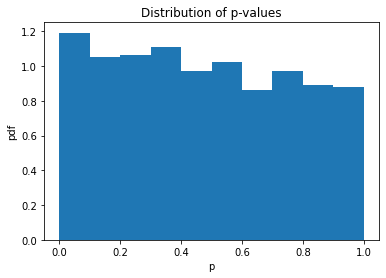

#### Turnover histograms:

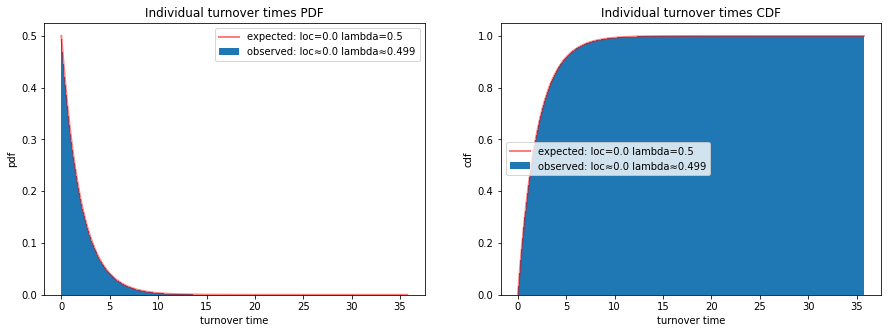

#### Parameters:
* seeds: [ 1596328879033447849  6335003106552198568  1992254538971918171
 11592631167249489286 14946111421494444573  5621135093907278763
  4714838852612260795  2490009913926279023 12910319988261917892
  5229823704729146257  3835671044262027859 11349168828318160730
  3433981976301866020  2959379067914685358  5807146956874817290
 12016355768188117503  5924124697216410307 14233145629712141890
  5767672406206605664  8051414810330657469  6855677155238391139
 17162130510657622260  4035918133685702144 12328656750596110585
  3142134412408043766  9486940768725108810  5289249622815363775
  1008718711514204039  7288326524629393918 13197776271736292773
 18041694396837444781  4734641601701824876  4635592100813361586
 15428753115747479353  7609606742162114366  3619665574001736139
  9061356546413283937 18111847713832807884  2008090292281071821
  8946027726947106546  5424826830461221303  1406869195805507365
  2961423437124394041  2136957430977088704  7651881853675296598
  5672549264917581372 10742966566463005842 15933778890484043465
 12265930869654766669  8402736777127673734  4198332058517324357
  7817345863299939292  6901358820803478333  8911904837904024024
 15006307200627697231 14636856050196248169 15093311225582966519
 12799349847687969256 10669097749586005168 10515811602539818643
 17292540967242923680 10368482828500264116 16981683906014389265
  5613630625130418064 15673502330912609165  7355270160980571770
  8898288258159259166 11564398459511556189  3047356750571532834
  8437039911545540253  4251050974595262966 11830835720836648156
 17255955376222490493  5235513760469837068  3255665031664958367
 13832896171224502715 10226157485246673009 16191684293938255882
  4090593992887676715 10490961598286310870 13417915342754222237
  4396777872919796206  3428903076177858861  9409852060947477270
 14837218025167294832  8792833648786606569  9560069020144506880
  9875144046543476109 13786701732317338496 14149700786233695481
  2642734991009062505  3964765618451455471  9237892174910386502
 16511398453023025144  3039303115261941766  8194468301503006639
 12980332246798048854 16256014994267948153  8042325800660484531
 16425776721167345863 12486834374092127797  4770195356551054584
  8970109882983412994  5805618487596937914  1934284470091164071
  1051752835054366462  9683504223346594121 10903177348898774962
 15159347340485728533  7237911377760164007  5950227354516604731
 16944751905968691408 10720766329465439308 10328032424847118110
  9344314923521340484 12942734230069713421  3987043586311397352
  5481292926571414302 12863298353173561592  1871348408341862575
  5528781599231275889 15985147625131868501 16898888775879479274
 15704393284493236385  1192492549755002278 12519951447934926073
  6115931891610094683  3357242708022477524  7372084431945904159
  6382804995194051513  7525021351998666295  4539943428470542180
 15280330800900714699   402403040377313345 15079395699602394668
  6822424052543253710 11353770611694773910  6502142898447666792
  2910038925733673859   134487548667766406   194851531996257452
  6727745108843499794 10674227660585002995   999420426366639120
  2891230082057964936 14715184628194090950  7027730654124831265
  3658991618816027050 18048931385748403863   163254290478796640
  5066080016637152271 14320884367264369140 10291731685186468679
  2795523652283986541 10813673847674245049  8749022088941465128
 14418988691212393430  4376086783124137490 17116165090874726585
 10653270234867737477  2327441339008307003 13943773007289944774
 14886727412576075476   329512007766725476  9935034653893310101
  8516946030619644361 17370100087106023107 15339423081750727421
  6629520516991714928    30657878412620493  3303277367895657394
  3165474787230237198  2859826724850548914   636606119557221532
 11581235364076676095 15018828158112714823  1413047138515405869
   755232424964743497 16803505345089682330   795811765538791085
  5518179447160802658 18020282185815355906   387285905884465087
 14050522574589102267  9603645312307964917 17673995473530096963
 11657701716430200911 14116420776334851995  3717516719394530200
   287206744925668766 15820119418635298393 14918497898611258799
 13548181939640942662   516680450607375110 14310672123856799570
  4868848667704994690  3436187368246566915 11430987848020736414
 11867176358885067624 16475169064718926179  7349216082854578539
 18413359939664917171 15574008611761468045 15207632073127178104
  2112850665407102927 12175517678826105309  4317474061777074505
   822926925596236596  9775162788020656572 12169524895533488585
 13307771593220550807  4240080778646365719  1479210624658467489
 11913749737150761060 14961275701968602794 11690143975562618165
 17597747171277227763   403745938574226405  1858267956432355059
 12761949643890293069 15731532528326619045 18106441098907754466
 10402232129539396628  8185804918647542685   422308349899856491
 13240652425541873242 16359047650860052868 12253178142869217986
  3300591273812784716 14742881460549170482  2386855451436818750
  7557688536421342085  3710976850918852234 10973853986937631427
  4334262420398086610  5934150203437810090  3783841794898101192
 14610055054331788297  8962713538179174289  5201452471669014821
  5292832165168522987  3430610569837435390 17492576517770564262
 12218885870014851559  1966476378803460553  5430136764742743748
 13361309600527497988 10399313801378088373  1971463543858240883
  5887110254996433939 16162825164358161658  5294267954129933860
 12813133287052438663 13144912940589002251  6179271366383987055
 12086192051487993524  3923091037708581612 15985653106387409340
 13506143546408369686 15183839109208779790  8989673273619175226
  5150895693175437992 11292486915306758973  2270757978008738664
  1415213066641115836  4334271617857037485   637509365591178553
  4147302464708068699  7797074793927503217  6399846277193301165
 10065215674188268404  9939320185420641423 14176366638466065765
 15026123827007731538  5764643842145801005  2042345594583052258
 14774168881688767587 11598589829195511000  4432672657789064481
 18413631863851547586  3500300325560188303 15781491695551088298
 16309597511528094773  7531927766700823539  2180639447019662082
  9456705295075626333 17482042155486284407  4940054542281124178
 11925895034428517002 12460855804203295247  2459762593444319874
 16411589104682499644  7930430002355556326  7169998206950426210
 14677807222217191133  9698127397150183325  9382850548472850410
  6235219321572864435 13427116377191371206    17747210148631140
  2334566025631343670  3462732292834091230 13045379745623293576
  1608754145936663534 16334110727031338555 12518316330442824499
 17791440068388480057 12164941395224806232  5963418564110618786
   499925643335977442  3327113490993606097  3718683061905358257
  7612004399054156561 10302309213137366646 11278591666439963093
  3989497017460152235 11686380612625244583  1817752326322416058
 14024042781071955189  6000280528528312800   809518151623732837
  1631807493295409757  5993880976308009645 16108025521970287447
  8467673622278735395  9285050712953048824  5159974613115626447
  2006137737830703270  8550902615797731861 12088840786834604290
  5508797072821212507 16513727988188757590  8384132310443310539
  4755673649805873058   910542698447328003  5866600556861279767
 12203526200872726085 10891322346226057698  6206282584277553407
 13498841914842295038   650238826767451154  4712510029237911303
  5194169603876858935  9396935162388301055  6532065926340720816
  9071519109668020193  4594779754978876901   763338502450539738
  1390610298300802652  8615862011080830127  5733791837040255499
   965731093395028599  5366262267774592725  4002764704506018981
  3640991650272458275 10066466267760860419  1730126062966232297
  4103865129709539299 14811627680399603250  9966997803938667513
  5386538693798801592  5385573557167829557 12650254051057934932
 16857923853729970399 15353572181649492147 10476937727647489285
  6917791878014356625 18073554721666905958   733294251141487888
  6969638490938711871 17488313149071247475 13091581080713929889
  9842469005198258705 10160010674698476371 10321574124562370123
  9896593573735433097  8208074127222162540  6835183497166145217
  4168890962186430297  3492772992124455383    41266012091700891
  9199321978465008441   764685816478015615 10867152894085279187
  4410082398909725797  1675147600949273124  1618733914538014796
 18074499808350291039 16935531937455446753 18119481244107435480
 16432312144982593606  9839508051471361652 13516798268253588661
 13066875424590615768  5753094238957120218  1528731674310453626
  5176801307211118220  8700624386024557898 17111777370005606227
 14971170265958501563  4886015475057982413  5106396190945123132
  3664192310635868141 18329863785713454868 18280788852242533130
 17512738598381724000  7493665485857089841  8594580237124667175
  2688743289038418685 15877271212400243025 14969763974419325031
 12766620252282245630 11609143023002638837  3536979582211257445
  9057353342432332332  7822217455386170343  1559102321004245693
  4544354501127254945  9251087235695008083  7708518599012289187
 14922121046213529846  1377711800501209330 15655520581363621716
 16761801502110711400  1692627355104662883 12607768285805563378
  4524874242431506606 10539243401758503320  2148471197579586162
  1547792119501162378 15984981919919477411 15450896724892415359
  7491273192264641390  5835100374461515177  9695142166024306070
  4128333684869064324 17839361236438740345 11571662601155132741
  8065778425043434708 11570894210778177699  9159008269203696474
 13465360026415709358 13655623673705805099 13385763670768388409
  6431938944511001527  6746057219665101581 16798475712065707825
  5260792630677674216 15285708421952419171   644498475794025654
  6544154265958553061 16443325076591668257  3408437715127616718
  3032122465468613038  8194239551478778329  8123567078330184569
  6319252333263875841  1401572330588539465  5048091917467144583
   806919174724587808  2730862976080798753  4156042613018982286
 13335081479863724442 11385950341148335445  7584338989833707883
 16395569464497853805 14214053916794064042  1918667954733613482
  9866819784030938156  9013498454725244772   166903797829322283
  2521577583145082872 12464448739553280331   153009878739136000
  1721465804106623471 18011046447536070586  7933435376570548402
  7215988918285445437  7779937403562657365  3459745871947453121
    37197059607706059 15883377831732052232 14086442253032027034
 18346272691911536288 15572980057202366864  7522332425765709954
  1934226823064807728  9699323876621505249  9216329936777434131
  4800481426383985839  3092037208729310678 13727610325452573187
 11266315490772859899 10787868968468740033    87851365828762270
  3610174146237061262 12335523391468496438  1818593006945538912
 17812797432785004118 15173379020469699192 17069766880125457396
 16163812021468072694 18143609140880654212 12047176279155469986
  4846980002715314174 17632147150718712939 17967411771317884220
 17559545134593180503  8721813595344531160  6724584803257572670
 15385913533587999960 11845213347017905820  6248227673691374118
  3964794748337148110 12235125788136474673 14728146302171524710
  5304328617440832335  5988588548816932651 13016422816602192255
  5068266857331471277  5462646034008206328  3878432250540161616
 17436561581109291330  4195859728044698936  3624714731803135594
  9581762729266954326  7738296387959709883  2112639645503263171
  2010366019175285429 17103490017491613426 12916348150659769708
  5026144520334660651 13774750489566342108 14621039112474676609
  5739515714343779772 16280658867907308559  6057146311810350443
  4462852652707566685  7602448532649146538  9323119846007886754
 13584737153169940004 12738497828729125210  7371141503913993173
 17430768931216704889 10987950051239973657 15915427483798347126
 10095639006935881865  4381858199015339849  3367326388978829043
  3856620405378733533 14750746695659931621 18053517349016871020
 15972440425865189263   203471569499332877  4888623369188412070
 16110258260987082047  4059136082674192838 17601120215282267978
   121435959142652909 17073605867423165035   763194525391252967
 17072026209628782907 18012872662689706310  4835848267227784318
  7270463384713232586  2034806952203117387 17598542259226533826
  8503609569119465385 16750697812462339746   336066990350705887
 11851540898057680546 12209813664841606837 12771205788618546943
 15308576308046641600  7031275474480076945  5408413182298704314
  6619993955423734422  9549396745604682200  7410917426829366441
  7916763541405058490  3667759398503774163 11235240636475073463
  3995516726640446467  8578449784076225385 10986626640282014498
  9576865744255907154  7428392261883135085 17602838162583563177
 12632414032820873592 11626267329386015699  3452830117451794712
 11562259898983446682 17977343637540466759 10673719529667194971
 13427530285123593511  5235984033336393508 15629523680828144244
 13821419822034051172  3997532366940200805  7631856635899870413
  4356706170040388725  7479160216584065632 11520158362736994899
  1034081826759375844  2857699137754213507   703528877654624784
 10843645362060433496  5767033580392331511  8528475895683043209
  2104359470830829009 11080348695673345998   926111011362943715
 16744273555146181629 15814339834091223980  4969672254541992729
  3553873406366347739  5330343424909740305  4283789155108016872
 12506171596534652651   786143148626051806  7169309796126492507
   516520835929782447 10386604044600622689 17731040367655107794
  3455759783527842946 12266142570740192125 10150224746495126927
 10496753875437264970  7240816279014344982   438121600593933314
  9005928530895258536 17224115352849964635  4684411437377399834
 18301639612329657737  9794265365282451611   898808035252443293
  4789149922044359600 11065434304793326992  1268378894966422580
  5668339889134116442  5291653766569056707 15458869294568781853
 10585394931615341680 18021406741178628777  1556729531257446339
  6185292874899726313 10922660413942893016 16799349205807997741
 10679155782019991496  5696668579776182600 10479755661364786356
  4921063542254638031 14784242919621805780 11620299669341498214
  1106666975290936543 16769410931142254612 14221891499747012381
  6166840436120745673 17060191428498814409  1679363470479653867
  1261677870484873971  4159982921114151831  6108695999676825491
 11931331215692010991 11816977431733764741 17690934586615984950
  1785347952573627179 13853017585760321368  3540075202793005337
  8115065230989380755 10741667107587632518 12175462515426057942
  4209009786910612106  3085110746017161532  3865846882358811291
 18199472950829009548 12805446636004913405  1035694167153126812
  4604701145051512120 16383554436164520666  5023589451201512124
 11449966752997374436 14996817839181305219 14977364707688458521
  8491739440443109655 10997955395470608946  5763804609008345325
   583837460160395198  5754096943609478117  2623028714938139100
  6773277027855502650  3060455683815716217  1778494373716243744
 17087658883499065351 12881602737336467051  4786431901686798489
 11103437660797572352  9434371671187383132  6009397703163871469
  3984577235013696460 12053588069689880479 14549926762516550581
  9886129796452015684 14085223149960727270  9292329360878867989
  9993454714921116623  9823255259449273986 10504254082697659140
  3693359025274288447  5133258898797298867  2050060105249718840
  7239883973401107868  7946544130083734472 13186489348898376830
  3239916050347180574 12259911285289015910   337485497925445846
  1762940664730622709  2023114744885575353  3599368886830862039
  2968008745745488674  7453335827442476894   726948479586032048
  4540187199238339940 15520898519009848415 15857256317948268389
 13050236741509847609   556746651477382463  9536938061297736822
  9043262196425943203 13375767604050729543  6744568141397519711
 15215589104786213656   628104952936014633 15334259250178391898
 13775880029375291179 16951363003090126429  6355815334546012078
 13630999592609946086  8280290386246737964  2390026630061740018
   816118535020357736 15719643097195449540  4301790501631457618
  5651699680834913866  8865480329623575071 14979501585969159254
  3634782353126545794 10380415030857887187 12361624597682281385
  4263218648139338455  8582309510682622196 10315850703601791660
   600843766405065614  1169336150952605264 14810402595216391528
  3461870849038851695  2685090232124931830  1381127181343060778
 14992990590706360506  9627663878821962933   810436776453104389
 17551287180038072686 15114696712149045019   615407367557643803
  4521618503405114127  1933234488568211143  6859385679844420298
 13789118804397161433 17901204947410038841 11768840866703634194
   429269710297047562  6543772491401511016  4277533525407751453
  9699026347174308636  3114530320084228950 12334499444882116233
 13233926949606197880  5544460174942397046   106117116670902772
 11084544063506141027 15857708226214134779  4319170781823963114
  5397097715766719069  5517912656931078734  4966056202268713795
  3386323631216394120 18148906839612832674 13798826638703753216
 15239233512083461660  3557352044125864072   761152345848670648
  7771073692894277701 10310326256361348361  4617092884450255285
  7220616416094672988 10487757330303987525 16876278452011450890
  6217635311368263301   179104488753163438  3209199212457669881
  3695713282403378785  8246161290953858084 17122104019463890603
  5859426544388488063 17761579339379546677 15136414271882232183
  4803486870853935515 16130058813799569401 11937081995448676400
 16207363616454458842 17480262816989445776  2058815081859963799
  2413921530013500130  3302193404128002827 15906121894934517694
  8590071368476881021  6949549998819646206  2410618815019647014
  3861713458606745766  3015890273027062408  9527609313365650571
 17456699392953340629  3578878302367926147 13999036578368460180
 10434926506400617022  2555179130755182018 13786999390061205406
  7040260751974701274 12511257916994351895 13470420464741439878
 16639386117734424129  6063271086613643522 15724386423145958165
 12414744968628418933 10098301495211309012  7731118224392659013
 12995431672033767198  4253797445730043897  8002082016609588451
  8164245795845434174  8711634534146838705 13136206933453895321
  2552349176249308228 16210127642306819038  5215368588188591463
 12312180795715631951 12005524338041675413    59564890501360673
 12631874525862696738 16396151505331325962 17524053859570618536
 15538073896880602663 12234775236172822059  3072527170085367247
 13163016471537598233  5121779596833657575  5639185173028999265
 13397300099567629275  9501752783475344220 14348664500186366904
 12358799023449710941  7932775896247682559 16380627824390773806
 15200680220193587343 13892919656526042024  7953334423592530716
   992457751559354556 16046965546787401821 16263500916867202285
   987027255133152620  6268827674022877674 13039317055384728665
 16941483204283340114 14391821664071980250 10347923653050335110
 15851345450534383678  4900665972585639258  7983347150588175765
 17718869604963063579 17219749528284658186  9446875609529468518
  4830104892269728311 11800879581534506232   188586261173019606
 17851104036908125910  7353476174792499854 10060027474625097236
  3644109076767903091 17121180032828823540  4385769650251183404
  1968438178176327409 10882797132175787658  3899478997417822244
   304443535606010261  6300374159980356277 13812276844567005577
 17417957682963989456  7287433917485964227 15854647912926360470
  4316172408545563296 11868759248469856750  8956932438157945616
 12955637502551163984 11557150774826926221  3023719717239511271
 17976436688303157179 14820474835230178049 16973728135977860839
  3339667816003506009  2371924136028198577  1791907412978721258
  3366893789549252114  5683833150259527355 13702598514081135400
 18215645884576541410  2288925083941079914  3928644810316346322
  7342139183609234564 10269451177103525016 10562134437460943370
  9273997868218397135  7563095365731738334  8483015771523656904
 11305171738505994134  3719688681039191168 16959337218854909916
  9874415301022743592 12700735223597053600    58619926828560358
 16022319537098527375  2527304783560515594 10761738620795266778
  6899526155933365852  8038921375920445788 11098699461084981276
 11181746176912122426  2258397979237024690  3586630104316002764
 14171887298005626473  9769962342356817621  7932212408968484645
  7669016269440553398  5170208762831838242 14590207332317758049
 17886057222513860325  6033869614232420134 12388236315710326916
  2071177199306674244 18245270641545845261 10905046170103696799
 11859493788086631525 11970362219878721309 13857587242971793556
 11129983213635035265  2223435421268607804 11504587390828038343
 15253759139528084141 13456440301630567964  7391090663104405005
  4349724859287048677 17474864439145169642  3911538603254557686
  2346086645639762566 12245379202832395778  5632594312860050683
 12553247961270109359  1087093440861791249 16132513443889718766
   533322702543000969 17852506203810555786  2501143643145930601
  3149118311511315708 10563424400355803628 12933245639579492074
  8826138196881190495  3096604370556817924 15659245126563861012
  8555967081868345100   448001640844831995  1538201190172758476
 10408078731963169086  4708387994644747042  6673752112496769459
  2363832593443476407  5721896295429296452  3349597386474496359
  8919179404464134135 11246472825939008567  3071071180036039660
 15879820662477958238  8268416059182616760  2336889657955620552
 15265504312955280852  6811285631020027682 16004701370415834882
 11706322001255905088 15942870543203675561  3299653235428844042
  9890319442775645642]

#### Configuration:
```rust
(speciation:0.001,seed:9890319442775645642,sample:0.1,algorithm:SkippingGillespie(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

## <span style='color:green'>Independent</span>

#### Fisher’s combined KS test:


* p-value: 0.6473896565632242
* statistic: 1975.5086350045503

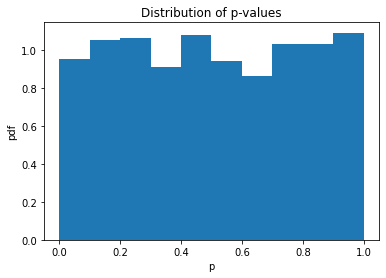

#### Turnover histograms:

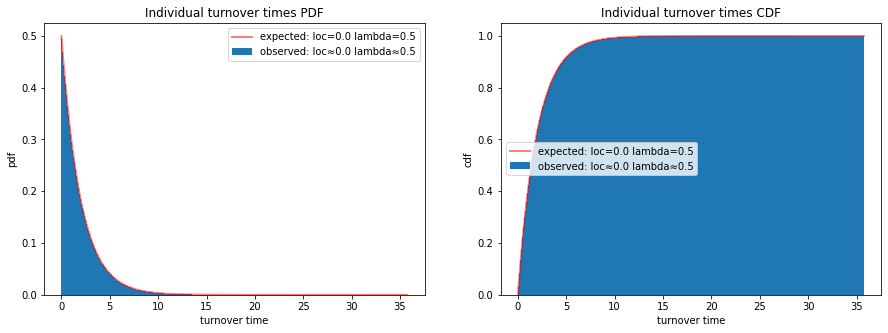

#### Parameters:
* seeds: [ 9251908169316217894  4088385834740574498  3327219325473378202
  8741339951025278785  1784354759602636589  6400126541546606511
 16844676664602207870  9401914076250460337  4562586837035439293
 15714689919493957067 15091228586071497548 12912986913275787155
   459058965633978417  8393442913131850069 11033022481604394365
  8078583902350591431  3666760390291139899  3296809641739191749
 17756787839292034883  2571224310708610633  1539072986368144391
 14483026760257305002 17079893069382558581  7761653705658930912
  3892260096313558385  5586381885644480949  2325655410565529428
  6426863002583749005 15718361434817172369  8332712386301503530
  9981279095699633487    29717198212277159  1949628397696166646
 11463020501383368378 13532006191477506464  4706740809059441914
  4906210890566150552 15337226081439321866  1824798712700563363
  3938793432994813454 13943693843561322122  1613461523428631308
  7068701763310770670  2264780542159848822  2467107023469302013
 14173315966793395079  7644333017912964226  7189728431978730798
  2114441240111002275   556671662164532033 13803575048930286299
 10011915954832853048  5271704367269304488 18378262990999484125
 15904290683089725769 15351483129569411800 17345661497016171431
 12192247914449728151 12930278299739893975  1241676950382571637
 17462990040464064331  6508177372428922790 11111028179828020886
  9648694316953829215 18076855596309486900  7688398529774686518
  9700841442010011136  4610209441436689657   955426332919707239
 16099593264235838383  2381143908785347510 15884160584966063514
  4363714610748695683 18280814868311522770  6662444220065461115
 11665720398983277293 16438271764058034660 17489152649169440633
   271527648414909920 11620148386641989909  4154869315827249973
 14899150298650212962 16691899745574558680 14073019146914380319
  4884769762410935215 15758581558584791049 11433050953739048964
 11642731390625714824  9479500809710657226  8153454702016438092
  4046841429716400349  4351786899624424176  8989574522125122005
  6366008114031652875 16298269200529587148  1449481130992785621
  2590792516441709564 14313538274696581288  6409541526034673249
  6918103411608093356  9109324100637295743  4847591717773658871
 14994929382645348520  2479064050205944243 17127223060524470853
 15102738808669492161 18249156825607293368  8604315676985452150
 16867375093552527853  1407593443691258933   337768926751245140
  4140085687920676179  5958280410302984851 15499468130759106873
  7050533511432022428  4246778401231558926 10594269479447680298
 11398915328223484192 12889249802789532864 12161576969323345697
  3845529254725182416  2265768496803539808 10268112705745831411
  5777065900557387171   880941152235933285  1055177996233284350
  4829259090308993109  7576736075771312033 13064148402541567589
 14921159764687033399 15801346073563983329  8156518090485576661
  7996793307291321482  5855219444042114789 11604330009189716414
  6301870196350714954  3300749176895488213 13267608957263915216
  2989992742555090420 14436645851728497436 15924831001591216251
 16558150632398156872 16298569941055630766 15775487490623321376
  5133873351126776343  8739735555816938439  4211974205881585616
 15987012876025719283 10272643229214553739  4647335568647319404
  1138935336470213326 11513032645582760200   307654248435934887
  9502102498630493071 12414999605459999236 16018652623529207987
 18422744284532195493  1878980809061211447   265422282089446088
  7712167391617914281  8371713882861399298   917658299602143164
  8644010579787094342  6610455080712874074  8185894851216515314
  7876292020651142905  3242915021160153816 17338640460043538528
 15063742872825387641   840241779209220830   669999392631322271
 10091090116118086307 10115660896372735511 16265419709032142331
   460790707858155217 13618497623152500991  8905412424838544866
 17326586918122155314 10517149534111547582 11192490995134954736
  7886930244629017122  8868579388602233255 11440312061142459660
  3200010717804623152  3348146449237771252 17714643276442498573
 11716700532339588331 13440242108381939030 11273954513271298462
 11609512158130351945  3917521536030753012  8427136485476174338
 14556963182161772851  6489601076818994302  4034409572294557873
 12784591317567179200  5231572059915678515  7016172412743356383
 18296106101028239560  8081941676647301560  1021947320109086094
 13668616407522987213  2662363648205948978 16970107926525004155
  5099271266803540559   977589603681610070 18436003621644968284
  3136140325599832517 11217795193729309528 16342823770706489533
  1341881925667583936 11705905650689652241 13044144386901210339
 11681208187824104319  1736379386196676523 18045627137229876676
 11937194343479102720 10569433288242704484  8944276126876094283
 16584222784704222264   647788794042038613  5258107019652070071
  9390762177922334358 17921581737959332669 10184583596000787359
  3057260113333985031  5746792229022230201  7766019847547809825
 16539442180082970611  2136012135949709531 16713337340370617207
 10469087307513698588 15001107678444727493 10171273788952699615
 11486461804581392810 16054659282983625653 16001689530016251738
  2891181830839809815 16877626026737010141 13720575696246571485
  8880443251935873827 14610524097895917850  1738687615467253331
   991171986952582521  2521684611712653465 16850281250117449139
 12286727367770591737 10847834590067345534  1446135181233130921
  5226344637366000988 10432635979222474829  2338484311403517141
 17045012576541853077 12613551098134203036  2548985847693854880
 15845527364550872273  8767094367739847809  6124085311086107210
  8233517795803366144   974017261541290034 12419893390226080206
  6166666597476109936  2404156058350239569 13975190165458269623
    80255342741505806 17312660959999634044  5896091145527221260
  2811713879113436924  5975806806284035040  5667809149903793759
 17227309820739215511  6344876904355626047 11715292009170316251
  2959166863434845425  6906079814878105822  5501815050973931740
  6843167201919440034  4177927071509487140  9854887899017775137
  5758309023924092744 13830053030397162071  4073473139174170412
  9263819120389141284  3886678109152122406  3519810910677280561
 16679817327556358251 13614874772586865999 15532802533682966732
 14329669618501668313 15616849119101806846  2142895809522197138
 11208284271897361209  4451277560949623655 16206231244304177449
  7585303170829571650  2451035187315647090 14605978317123894997
   447145851735254897 16869616510552812329  4500803874475694638
  5057361619549678400  6372558131454983140 16338978356701826905
  1486471405989445726 12252182313341987226 15116773211637913310
  8595518875938753944  7307343991333848368  4004324148989420173
 15042311490806010308 12472494339155513951  9958432236151447908
  5925601733237529244  3355122015147870393  7477127630715738963
 13795351488367073636 18086507024015331609 16187433109300006370
   528143652025497001 12922194047012478584 17519997592774620917
  3985216320516199457 17174826947082109058  8360562651081284467
 10853917516097977030 18317500805358356276  6599149654313077031
   856659149809707053  2971998264235905187   748889633636376104
 11219140862130568290  8900856605492168578  3981020586843638982
 16783590536526766749  1476892743574493001  1369067908886186939
  6211163326746016139 13746326823835619308 12823245562718806245
  7524159794316445745  6132661515544087789  4318808247139612081
  3357570275985334060  2349473582581585914 17114593065430768042
 14810062566303968270  7933256472469650801 11054577294629755064
  3918954757505008690 12583927734899629222  7718519722740219525
 16241041808357266955 18335012180150723708 13475202388589750052
  2440613075661038803  4749034479652747002  4580645447148528116
  4960152504488232061  6093338899300996487 10652057964044211408
  4632147766203675091  4129304690877803857 12561311229461126975
 10892062499343302221  8283801666894179082 16741046433545454816
  9091569512547859780 13298772214347630851 10583175641134511057
 17153470091983488733  9280672890231820422  3674252241770850067
 17582665964029432212 16081857152673528871 10254638585611505087
 12852457772568243310  7382334866391945231 16677380825985181655
  6941294306563565128  2094108916263684436  9416018695491365482
 17479952862261860917  9180154729236855971 17006828807468217716
 12327085803223215883  8665426400668881463 12352650586291941962
 16197252377665647734  2038762994512615997 15075758943038767904
 16501245751595754742 16685398591455314078 11856967918177878731
   544069069028153006 12939602984606851613 14633510654549713269
  3008135789133787500 11996002543489971399 18038976322214179137
  5065861962064682069 16277486648656485485  7236155235623146232
  8798890163232154619 13672155040691971206 16599846312693622865
 14998977375631912306  2250546004787475317  1597707782597868299
  6170814464004068735   881157227225773202 13391310944084466507
  1286060046407952929  1358839452215476554  9840519720710045873
 13594619698389511176 17317436676737791335  9780756512973857890
 13396702001944627606  6071372148608386553  7840321829666890577
  7432301093839848033  2893582890748008037  9361705967812809267
  4626285568419637670  4304553297400458941  8950889650618993868
 13039835792581275960 14565733486164596075  8767510728199416953
 10428422842830699825  4188496273639627817 11964702038202268165
  8529468744948941393  8473145275737122067  7907695458051781140
  1194424078153274293  2809761037290021189 12112508493303499814
  2626856895240106699 10822596934435750296 17807806236563796881
 10499829776443015155  4465989880102125592 11512204923701725163
  3403304686912947036 14534562800818850625  9435484034491285215
 10766554997572604214 14470385150522619904  8922455581642666119
 14811760166407672685 11505557150725942074 11792770803769230886
  7480355284233275834  1998998825737879893  4010487731696805721
  2314838361607017564  9415320295790729613  4676439254141471055
   142217828674704670 13835982946347018295  6271966775170751842
  3650510280411582180  1484248689022911898 12698254412569921554
  8846442314976130389 13626663659676809541  7418721248723063474
 14186102321083571306  4305418186301583311 15942501207033655774
 10437612290005592608  7268351182368390323  9913834667139749480
 14970505508228773311  6140794986866544376   352487040122374644
  4870559932352954925 18203006712920851827   648914170811649840
 16417676856199846852  5431241736126844551  5862338615619792986
   114072307400544134 17911839931511942382  7276656205680598801
 16343390595804475218 15749625589891881489  2234569700194881106
  4526946074861554852  5667640099174445972  1847916651042336390
   955027443078427440  1994437548791861857  8551135070645829321
 15871039216100572166 17248630189336804879 17564450452377818898
 10562602025270139931 14994176373757833661  7029958068211486766
  3020835327141472890  4897412919621027996 11520729323236994576
 13980242596466376912  5923640899187223437 12055334540765894239
 13085087815728031477   716076126917416020 17087365346683022285
 10777782602842221232  2015901809909640267 15929648679455655500
  4423910893424127938  5248701633704916179  7312727835969946557
  1449588941429837335 14321596953795205567 10588129849425897443
  7618279609116066441 13011972265167370282  5221551686156967059
  2661421402897333468 15148857823872492961 12299445370293784225
 16461553750152610342  8373298560468204977  7867721407729058387
  5046931217620237859  3787186379198097044 13301954990152201523
  4630326313165807079 15992189247454896484  8331518593193514234
 11961992759605562063  7061748630525529191  9051504651625344693
  5524113179258536142 11697353178738832496 14692287815683604542
  7899130398951444529 17631761810551710964     3118195338609458
  3136414496209937698 13855661971988801380  4419353476065495289
 11916573328537064728  2400196475884513816 18063821027025392379
 17042692467085774320 18264757396603383994  6413186367478468519
  9852679870912651703  6473306349339284694  7163335970814184583
  8586724347219686504 17955479768007975191  8667498622996132165
 16227427217540764843  9579562391706266618  7676307873662394578
  3775248484906729074  5227438243877651467 18095581693416854021
  7269097618602383078  2098402125210069651  4008196939529877041
 10000681869684191929  2777010924398008766  3477342091752678083
 16161026598225325644  7273760662794659033 14437961032306122615
 17402780203976581659 18138300217312332126  3491324312044823915
  1028295849439651701 10631019174240471179 14707349443063847004
 17384641303692142445  4671560630637683847 15323313918605147306
 10672838008324981769 17779047500431663612 17531942618662480318
  2600436103129269927  1033556832159208036 10215958242504523347
 14623042014393910238  3932503621293742170  5620361775452803305
 14389028677548373643  6206507851006184375  1478526619898314299
  1005618967164119338 10810546875795697634 10536428505421844514
  8409187999502310134  4802381863975254926  2574047775842414013
  3253404881975398291  1879839206609468536  3737372474548904026
 16981833178946951509 18009825904138219096  7543467359254700954
  6723083970814199202 14380102276521354808 10724781237432858642
  6206230650410958027  7425468584124715792 12311176387225690369
 10397350927458392411   589285045765060263 10277675369324505383
 10488766311967628271 14449792981260546208 17674102037671101851
  2684247911303870766 12933406751085244621  8215668426677894043
  5390856249846159285  6172189747881865488  7781761853513722408
 16153054825033875999  2851415506705420240 14685106242131436287
  5654018906146615404  7797796855118937120  9742302391872443081
  5627359605050739791  1833762013374077992  7535396231768930871
  5248780398770989445 13922209441925882776 15035811259700129151
  2909433104899500608   719319181211882874  5643700395458668339
 17673322450741663561 13157376724474322281 11659592612098408289
 14053007773291428386 11852711372338187346  8374165637006906731
 17195830182278101798  1085791167473221282  5442178628122328970
  6351527732659892052  3147180732289492200  9401851141480076470
  8040396428717028014 17205767115822567263 14240001686824666491
  8156367527753502590  1884951966739574617 15881389291644502648
  4375529676634187295  5681553167859464423 15682513760256252695
  9383716485903903656  9763960777682564295  8279655657821943032
 13058147993922522548 15089260905768785681  9569452909147563457
 15880960610207891728 14755944411993423181 16991875157957900061
 17443022914782584178  3098260815782732496 18291664634479942659
 14669021758714496607  1860543648022367203  3983660579390198091
 16055487267188781093 15728515038002211779  9698003593839093649
  8338445722321253265  2481804909174228674 17025732753112396405
  8991913981001350263 11695209356140750252   581875470352949884
  5474810122875999118 15626981926758857167   679148492456574967
  5096337105500322589 18051135575766622651  9666442882884361403
 11257538805291434049  4550032843801776626 17671799583003172881
  6432468549043544337  9246900610740727297  4571801187792823456
  5567390181291739501 12043329925534491758  7351035325608152661
 17994959692654237113  7147508736231305806 11090890009545255827
 13479347813239551842 18198169891260445725  3056244139433820303
  8938384165115554739 16715059397013953018 16346550057258751320
  7544235071771673930 14583021851616991746  3267575710666376568
 12428952519540900604 12694717514266612516 13923927651968867457
   714785997465881062   684355312349288079 15723882184373893372
   783065598279476332 16980925453944063993  9943896554829661151
  7165512681651922951  2013445418644702569  6834972621695646173
  8447599626054544900  3158856427347922034  4163911378496960240
  8933520223304308454  5772112425571524467 13159365979141980173
 12652548176783887497 13544151421886411869 17873771972808499882
  3017941658386063715   164223121188338738  5147361578762905464
  9714021029657922028 15962306964632640301  3885476116551876103
 14656730234310957984 14479192265667445431 10700444426346353621
 15595319976954862213 16082852708873990901 15960009600770527315
  8986653192376146152 14838647396252264862  5795860119175223468
 16081631080655552919  4592087352115467121  3802933453089534945
  3703748028554677353 11263206576563270381  6828060578536270057
 11479095888504830045 11881430097597755314 15355858545421246470
 10158293356921457238  1340465500751660925 17254310672274771498
 17564116941361906957  4167545130333494154 11645456187001599038
 15422075050981208591  3167283377811217661 17941110915678330728
  8841759243875391170   502968289407250870 10487263433544588928
  9057824777801618325  8984245142406880118   748939890552619864
  2917741221677758286  6382947076070222648 11892783995528722658
  1640033095087511335  4316836784898182977  6351669636950109384
  8872927534989687149  8313013097301339252  9991274730095475474
  7054753025768815116  5634680153420957551  3084321364090975489
  4641267273288103402 17797270575091112230  5530195158272312751
 10262921777267689063  2088248467526723984 17667779535252186369
 15240808761340555408  9879620376980058184 10504643012007278096
  5268670973814599862 17151269113035274906 18376628275634359719
 11177191614883696470  8045147954787956791 11032794949734464792
  9219556393988353981  7456425754329436120  2957444440681379176
  4829299841626531450  7719250088797163291  9513731065545501477
  9944885945803722398  2167759756094381016  4618628368800332146
 17810835518199053130 17944322251730239840 17460207684106208882
  1008312529400947157  2986477626491737653 16842825295667695103
  6195702520160052132 14078354793564037061 15500635059684670769
  6795483898272849128 16706495615861775377  8575276756724026803
  9452369588397186378 18441934977361145549 12957836390274166689
  8202958762626167770 11939200036075691345   896307073772024624
 17832134671254799460  6956227761405520971 17919061517647715041
 17448485635562690120 14082207946045809962 13641671189928463084
 16363241467788756790 13618168032832063338  6105237569672378857
 17541035162830014266  3904233971117817447  2895682340761154682
 10015547481826727711  9240530844288135043 14812278148906798103
 10124642410836384373  9763865166079457323 10841484842516045952
 15047976257732454573  5538606322001272948 14508301350047126134
  7350822588577375713  6010001474867448564 10571487059591290047
  6446587156388441128  2502735786357678888  9454558596042110406
 13218796281917157454  9460053683646392151 17923700958030476807
 15100392928784161797  9027342036669061175  2787489600599602349
 10978952481653960295  9011721965911904366 15865528146388521165
  6945163823981838083 14339305525324284665 10628976543155854681
 12672836378790771491 16384540967624488829 11031456145951572626
  5454909135549538219 12104898758504069407 13432300191196080516
  5243151296288703257  9836106454367131283 10340302317708307663
 16303096352055461932  9850379998884379489  3767315534158347175
  4232335365367662830 17801515808594938460  7616935977991298752
  3004879324282247805 15308839483955726807   423527388324165293
  9125136611197461654  4040498222390277452 13642512845441419324
  9492534184247136948 17141968973008107269 11018241462694960786
  2957560701219413654 13725005228051763785  3632196103793662378
  7450963636277481187 14198865503129842006  4820482815688131319
  3271152634308947240  8725706629289231839 12862524870288263880
 12776221310816950276 10613176666218624005  1107620102337587225
 16988130449712182681 11800082770001154746 13750862744840903730
 16777096616201147749  4002288070042829939 10851170594218475459
 15378829002598589233 11471849098294800158 12916650105280074156
  1674332457932143711  9470148371637676344 15314079283544141213
 18136690434949142995  1321459665060890739 13586253175556172134
  1315671481822527788 12878358434157281832 11394399877278588454
  9860598758680116972  7642057871220034314 13966565048211844023
 16732880139143490492  5498854607417334488  8955498009324932275
  3499241648845574456 14649998555434799787  2309748250919059268
 12246390173201445924 12770513329734071170  9561173766808373714
  8887908560299089899 17193648339425862305 13296518924156863782
 11758507424348623235  9642497027095400164  5202824568001674049
 16231940165735906586  4004835266279274799  7777391001377590365
 11688938714427256639  6589279270545126352   500455321101488293
  2493345521626294436 15265055386977416705  2863453199271207406
  2784120241866722677 13466929670665147671 13405970618527701440
 12862105898932266433  9263461255267466688  3417367542174991179
 13529745331672872911  4517049818652281439  2887571422156698600
  5359184436300090307  7969987279134579003 18422084369730544944
 10248789520109477849 15781550034336833317  4844812076408901934
 12132805768430402949 12144657518011088705  6828527518681234036
 15800521336329841393 11897480480843471163  6183406590044771328
  3466159474023011132  3903976571796118670   741243506354167156
 13269701770362438903 16842871193822432793  7133191686734484054
  7519565505429108936  9455475545061406678  1070519374421380818
 10090511228104566721  8562824537256818489 18197386905228110241
  6704065799205267205   182753074807894347  4254366499024625871
  5638227268428380707 16772049792281019582 14062196219198872092
  5101320138438872681  1819506489822548644  4575374363272620564
   412214623317171521  6852521882765256577 16543994372594315710
  8274192703476712521  4687033218435590017 18275682745368915324
  8658030337921990291 16763463598895413906  6266619516550772469
 17271258053981360174  9754524951337703014 16597973608913281117
  1331116230848279764]

#### Configuration:
```rust
(speciation:0.001,seed:1331116230848279764,sample:0.1,algorithm:Independent(),scenario:NonSpatial(area:(25,25),deme:25),reporters:[Plugin(library:"/workspace/necsim-rust/target/release/deps/libnecsim_plugins_statistics.so",reporters:[GlobalTurnover(output:"/dev/fd/2")])])
```

In [4]:
for algorithm in ["Classical", "Gillespie", "SkippingGillespie", "Independent"]:
    seeds = np.random.randint(0, np.iinfo("uint64").max, dtype="uint64", size=1000)
    
    test_turnover_time(algorithm, speciation=0.001, seeds=seeds, sample=0.1, size=25)